In [71]:
import numpy as np

##**Problem 1 2 3 is in the implementation of Stratch SVM Classifier**

In [72]:
from sklearn.metrics import accuracy_score

class ScratchSVMClassifier():
    """
    Scratch implementation of SVM classifier
    Parameters
    ----------
    num_iter : int
      Number of iterations
    lr : float
      Learning rate
    kernel : str
      Kernel type. Linear kernel (linear) or polynomial kernel (polly)
    threshold : float
      Threshold for choosing a support vector
    verbose : bool
      True to output the learning process
    Attributes
    ----------
    self.n_support_vectors : int
      Number of support vectors
    self.index_support_vectors : The following form of ndarray, shape (n_support_vectors,)
      Support vector index
    self.X_sv :  The following forms of ndarray, shape (n_support_vectors, n_features)
      Support vector features
    self.lam_sv :  The following forms of ndarray, shape (n_support_vectors, 1)
      Support vector undetermined multiplier
    self.y_sv :  The following forms of ndarray, shape (n_support_vectors, 1)
      Support vector label
    """
    def __init__(self, num_iter=100, lr=0.01, kernel='linear', 
                 gamma=1, degree=1, theta=1, threshold=1e-5,
                 random_state=None, verbose=False):
        # Record hyperparameters as attributes
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.theta = theta
        self.threshold = threshold
        self.verbose = verbose
        np.random.seed(random_state)
    
    def _kernel_func(self, X1, X2):
        if self.kernel == 'linear':
            self.gamma = 1
            self.theta = 0
            self.degree = 1
        return (self.gamma * np.dot(X1, X2.T) + self.theta) ** self.degree
    
    def _steepest_descent(self, X, y):
        for i in range(len(X)):
            grad = 1 - np.dot(self.lambda_ * y[i] * y, self._kernel_func(X[i], X))
            lambda_new = self.lambda_[i] + self.lr * grad
            self.lambda_[i] = max(0, lambda_new)

    def fit(self, X, y, X_val=None, y_val=None):
        """
        Learn the SVM classifier. If verification data is input, the accuracy for it is also calculated for each iteration.
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        X_val : ndarray, shape (n_samples, n_features)
            Features of verification data
        y_val : The following form of ndarray, shape (n_samples,)
            Correct value of verification data
        """
        # Initialize lambdas
        self.lambda_ = np.random.rand(len(y))

        # Generalize classes
        self.ylabel = np.unique(y)
        y = np.where(y == self.ylabel[0], -1, 1)
        if X_val is not None and y_val is not None:
          y_val = np.where(y_val == self.ylabel[0], -1, 1)

        for i in range(self.iter):
            self._steepest_descent(X, y)
            if self.verbose:
                print('Iteration:', i, "- Lambda:", self.lambda_)
                if X_val is not None and y_val is not None:
                  print(f'Accuracy on verification data: {accuracy_score(self.predict(X_val), y_val)}')
        
        # Support vector determination
        self.index_support_vectors = np.where(self.lambda_ > self.threshold)
        self.support_vectors_ = X[self.index_support_vectors]
        self.y_sv = y[self.index_support_vectors]
        self.lam_sv = self.lambda_[self.index_support_vectors]
        self.n_support_ = len(self.y_sv)

    def predict(self, X):
        """
        Estimate the label using the SVM classifier.
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            sample
        Returns
        -------
            The following form of ndarray, shape (n_samples, 1)
            Estimated result by SVM classifier
        """
        y_pred = np.dot(self.lam_sv * self.y_sv, self._kernel_func(X, self.support_vectors_).T)
        return np.where(y_pred >= 0, self.ylabel[1], self.ylabel[0])

##Load Simple Dataset 1

In [73]:
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, n_samples // 2)
f1 = np.random.multivariate_normal(f1, cov, n_samples // 2)
X = np.concatenate([f0, f1])
y = np.concatenate([
    np.full(n_samples // 2, 1),
    np.full(n_samples // 2, -1)
])

##**Problem 4**
##Learning and estimation

##Preprocess data

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

##Testing on sklearn SVC (Support Vector Classifier) model

In [75]:
from sklearn.metrics import classification_report
from sklearn.svm import SVC

sklearn_svc = SVC(kernel='linear', tol=1e-5, max_iter=100, random_state=0)
sklearn_svc.fit(X_train, y_train)
y_pred_sklearn = sklearn_svc.predict(X_val)
print(classification_report(y_val, y_pred_sklearn))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        49

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



##Testing on Scratch model

In [76]:
scratch_model = ScratchSVMClassifier(num_iter=100, random_state=0)
scratch_model.fit(X_train, y_train)
y_pred_scratch = sklearn_svc.predict(X_val)
print(classification_report(y_val, y_pred_scratch))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        49

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



The 2 models perform the same

##**Problem 5**
##Visualization of decision area

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

def plot_decision_region(X, y, model, step=0.01, title="Decision region", xlabel="xlabel",
                         ylabel="ylabel", targets=[0, 1], figsize=(12, 12)):
    # Setting
    scatter_colors = ["red", "blue"]
    contourf_colors = ["pink", "skyblue"]
    n_class = len(targets)

    mesh_f0, mesh_f1 = np.meshgrid(np.arange(np.min(X[:,0]) - 0.5, np.max(X[:,0]) + 0.5, step),
                                   np.arange(np.min(X[:,1]) - 0.5, np.max(X[:,1]) + 0.5, step))
    mesh = np.c_[np.ravel(mesh_f0), np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    
    # Plot
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class - 1, cmap=ListedColormap(contourf_colors))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class - 1, colors='y', alpha=0.5)

    for i, target in enumerate(set(y)):
        plt.scatter(X[y == target][:, 0], X[y == target][:, 1],
                    s=80, color=scatter_colors[i], label=targets[i], marker='o')
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                color='yellow', s=80)
    patches = [Patch(color=scatter_colors[i], label=targets[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

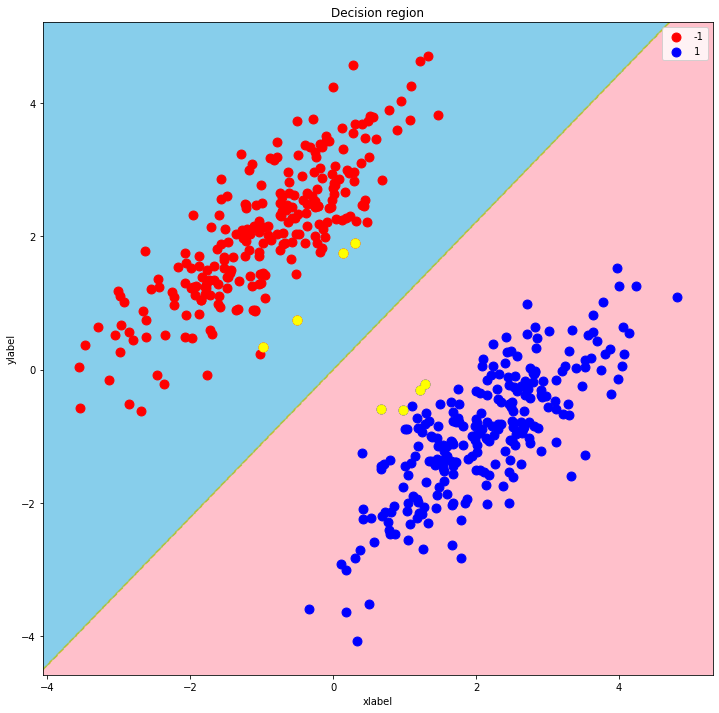

In [78]:
plot_decision_region(X, y, scratch_model, targets=np.unique(y))

##**Problem 6**
##(Advance task) Creation of polynomial kernel function

In [79]:
def generate_circle_points(r, label, n=500):
    rs = np.random.random(n)
    X = np.c_[r * np.cos(2 * np.pi *rs), r * np.sin(2 * np.pi * rs)]
    y = [label for _ in range(n)]
    return X, y

X1, y1 = generate_circle_points(1., -1)
X2, y2 = generate_circle_points(2., 1)
X = np.r_[X1, X2]
y = np.r_[y1, y2]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [80]:
scratch_model_poly = ScratchSVMClassifier(num_iter=100, kernel='poly', degree=3, random_state=0)
scratch_model_poly.fit(X_train, y_train)
y_pred_scratch_poly = sklearn_svc.predict(X_val)
print(classification_report(y_val, y_pred_scratch_poly))

              precision    recall  f1-score   support

          -1       0.44      0.45      0.44        98
           1       0.45      0.44      0.45       102

    accuracy                           0.45       200
   macro avg       0.45      0.45      0.44       200
weighted avg       0.45      0.45      0.45       200



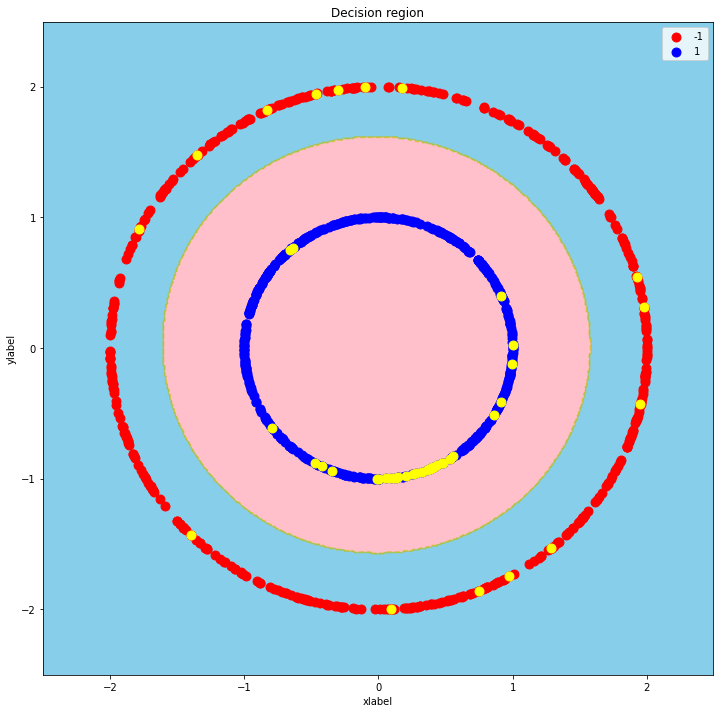

In [81]:
plot_decision_region(X, y, scratch_model_poly, targets=np.unique(y))

In [82]:
sklearn_svc_poly = SVC(kernel='poly', tol=1e-5, max_iter=10000, random_state=0)
sklearn_svc_poly.fit(X_train, y_train)
y_pred_sklearn_poly = sklearn_svc_poly.predict(X_val)
print(classification_report(y_val, y_pred_sklearn_poly))

              precision    recall  f1-score   support

          -1       0.63      1.00      0.77        98
           1       1.00      0.44      0.61       102

    accuracy                           0.71       200
   macro avg       0.82      0.72      0.69       200
weighted avg       0.82      0.71      0.69       200



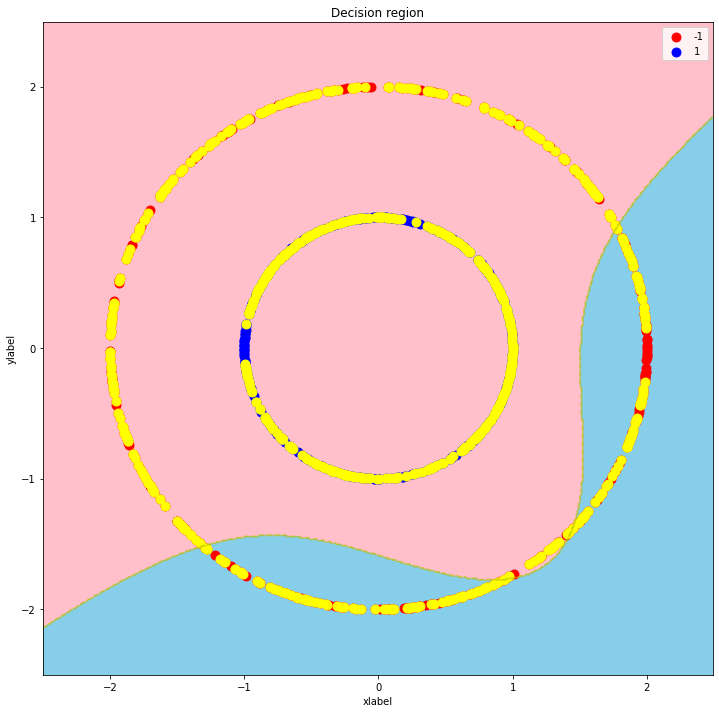

In [83]:
plot_decision_region(X, y, sklearn_svc_poly, targets=np.unique(y))

The sklearn model performs better because it was trained with more iterations.